In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/bttai-ajl-2025'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# Stuff to reload when you revisit the model

import pandas as pd
import pickle
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# model
model = load_model('final_efficientnetb3_model.keras')

# label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# train/val data
train_df = pd.read_csv('train_df.csv')
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')

# training history
with open('history_finetune.json', 'r') as f:
    history_finetune = json.load(f)

train_data['encoded_label'] = train_data['encoded_label'].astype(str)
val_data['encoded_label'] = val_data['encoded_label'].astype(str)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.6, 1.4],
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 7. Create generator function again
def create_generator(datagen, dataframe, batch_size=32, target_size=(128, 128), shuffle=True):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='file_path',
        y_col='encoded_label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        validate_filenames=True,
        shuffle=shuffle
    )

# 8. Recreate generators
train_generator = create_generator(train_datagen, train_data, shuffle=True)
val_generator = create_generator(val_datagen, val_data, shuffle=False)



Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 6720 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1680 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


In [3]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

In [4]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Unzip Dataset
!unzip "/content/drive/My Drive/bttai-ajl-2025.zip" -d "/content/dataset"

# 3. Load Data
train_df = pd.read_csv('/content/dataset/train.csv')
test_df = pd.read_csv('/content/dataset/test.csv')

# 4. Add .jpg extension to md5hash column
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# 5. Create file paths
train_df['file_path'] = '/content/dataset/train/train/' + train_df['label'] + '/' + train_df['md5hash']
test_df['file_path'] = '/content/dataset/test/test/' + test_df['md5hash']

Mounted at /content/drive
Archive:  /content/drive/My Drive/bttai-ajl-2025.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/test/test/000e8dd5ee75dd6668e978e7a4e6fe54.jpg  
  inflating: /content/dataset/test/test/0097275da3cb707415d13d2c59cf8c8c.jpg  
  inflating: /content/dataset/test/test/009c75339a21bb84a6425be6a95938d6.jpg  
  inflating: /content/dataset/test/test/016abe4884715af85cd3f309f93b9641.jpg  
  inflating: /content/dataset/test/test/018504389f4fa566232eb6e3ff838cb8.jpg  
  inflating: /content/dataset/test/test/01ba602def4506d8bfd5900cccd2ab4d.jpg  
  inflating: /content/dataset/test/test/024a737cf57eda5493e8cb30551b4e97.jpg  
  inflating: /content/dataset/test/test/0325ba9f88358e11a6abc3a63e584bf6.jpg  
  inflating: /content/dataset/test/test/032a4ac5c1a3a8a90f6e7aede2d1ab64.jpg  
  inflating: /content/dataset/test/test/0353409eed089c8165db5a968cf2c43f.jpg  
  inflating: /content/dataset/test/t

In [8]:
# Check the first few rows to understand the structure
print(train_df.head())

                                           file_path  \
0  sampled_train_data/basal-cell-carcinoma-morphe...   
1  sampled_train_data/dermatofibroma/aug_dermatof...   
2  sampled_train_data/squamous-cell-carcinoma/958...   
3  sampled_train_data/mycosis-fungoides/aug_mycos...   
4  sampled_train_data/epidermal-nevus/f2bc5704dc1...   

                              label  encoded_label  
0  basal-cell-carcinoma-morpheiform              4  
1                    dermatofibroma              5  
2           squamous-cell-carcinoma             19  
3                 mycosis-fungoides             15  
4                   epidermal-nevus              9  


In [9]:
assert os.path.exists('/content/dataset/train.csv'), "Train CSV not found!"
assert os.path.exists('/content/dataset/test.csv'), "Test CSV not found!"

In [10]:
print(train_df.head())
print(test_df.head())

                                           file_path  \
0  sampled_train_data/basal-cell-carcinoma-morphe...   
1  sampled_train_data/dermatofibroma/aug_dermatof...   
2  sampled_train_data/squamous-cell-carcinoma/958...   
3  sampled_train_data/mycosis-fungoides/aug_mycos...   
4  sampled_train_data/epidermal-nevus/f2bc5704dc1...   

                              label  encoded_label  
0  basal-cell-carcinoma-morpheiform              4  
1                    dermatofibroma              5  
2           squamous-cell-carcinoma             19  
3                 mycosis-fungoides             15  
4                   epidermal-nevus              9  
                                md5hash  fitzpatrick_scale  \
0  0844ae634f0e6e7ef1f73c2aeecbae0e.jpg                  2   
1  3b290d262098f761d719aa07cf36c040.jpg                  4   
2  cf561d08ac46d0fda678bff6621005ee.jpg                  2   
3  e6371069be05c6b0a95b4b3f1bacc9a5.jpg                  4   
4  f76cddb37265f97508f159078dcc7e7c

In [11]:
print("Train CSV shape:", train_df.shape)
print("Test CSV shape:", test_df.shape)

Train CSV shape: (8400, 3)
Test CSV shape: (1227, 6)


In [12]:
missing_files = train_df[~train_df["file_path"].apply(os.path.exists)]
print(f"Missing train images: {len(missing_files)}")
print(missing_files.head())

Missing train images: 8400
                                           file_path  \
0  sampled_train_data/basal-cell-carcinoma-morphe...   
1  sampled_train_data/dermatofibroma/aug_dermatof...   
2  sampled_train_data/squamous-cell-carcinoma/958...   
3  sampled_train_data/mycosis-fungoides/aug_mycos...   
4  sampled_train_data/epidermal-nevus/f2bc5704dc1...   

                              label  encoded_label  
0  basal-cell-carcinoma-morpheiform              4  
1                    dermatofibroma              5  
2           squamous-cell-carcinoma             19  
3                 mycosis-fungoides             15  
4                   epidermal-nevus              9  


In [13]:
print(train_df["label"].value_counts())

label
basal-cell-carcinoma-morpheiform      400
dermatofibroma                        400
squamous-cell-carcinoma               400
mycosis-fungoides                     400
epidermal-nevus                       400
actinic-keratosis                     400
acne                                  400
dyshidrotic-eczema                    400
prurigo-nodularis                     400
eczema                                400
melanoma                              400
basal-cell-carcinoma                  400
folliculitis                          400
superficial-spreading-melanoma-ssm    400
keloid                                400
pyogenic-granuloma                    400
malignant-melanoma                    400
kaposi-sarcoma                        400
seborrheic-keratosis                  400
dermatomyositis                       400
acne-vulgaris                         400
Name: count, dtype: int64


In [14]:
print("Unique labels:", train_df["label"].nunique())

Unique labels: 21


In [15]:
print("Train generator class indices:", train_generator.class_indices)
print("Validation generator class indices:", val_generator.class_indices)
print("Label encoder classes:", label_encoder.classes_)

Train generator class indices: {}
Validation generator class indices: {}
Label encoder classes: ['acne' 'acne-vulgaris' 'actinic-keratosis' 'basal-cell-carcinoma'
 'basal-cell-carcinoma-morpheiform' 'dermatofibroma' 'dermatomyositis'
 'dyshidrotic-eczema' 'eczema' 'epidermal-nevus' 'folliculitis'
 'kaposi-sarcoma' 'keloid' 'malignant-melanoma' 'melanoma'
 'mycosis-fungoides' 'prurigo-nodularis' 'pyogenic-granuloma'
 'seborrheic-keratosis' 'squamous-cell-carcinoma'
 'superficial-spreading-melanoma-ssm']


In [16]:
print(train_generator.class_indices)
print(label_encoder.classes_)

{}
['acne' 'acne-vulgaris' 'actinic-keratosis' 'basal-cell-carcinoma'
 'basal-cell-carcinoma-morpheiform' 'dermatofibroma' 'dermatomyositis'
 'dyshidrotic-eczema' 'eczema' 'epidermal-nevus' 'folliculitis'
 'kaposi-sarcoma' 'keloid' 'malignant-melanoma' 'melanoma'
 'mycosis-fungoides' 'prurigo-nodularis' 'pyogenic-granuloma'
 'seborrheic-keratosis' 'squamous-cell-carcinoma'
 'superficial-spreading-melanoma-ssm']


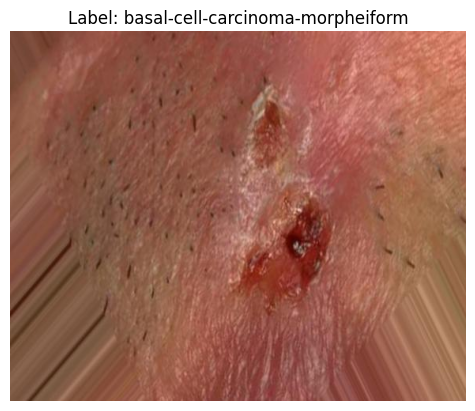

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(train_df['file_path'].iloc[0])

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f"Label: {train_df['label'].iloc[0]}")
plt.show()

In [17]:
import os
import random
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img




# Referenced FINAL-BT-sampling_data.ipynb

TARGET_SAMPLE_SIZE = 400

augmenter = ImageDataGenerator( # we use this image augmentation if we need extra images to meet TARGET_SAMPLE_SIZE
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.35,
    horizontal_flip=True,
    brightness_range=[0.6, 1.5],
    fill_mode="nearest"
)

def augment_image(image_path):
    """Applies random augmentation to an image and returns a new image."""
    img = load_img(image_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    aug_iter = augmenter.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]
    return array_to_img(aug_img)

def sample_files_from_directories(base_dir):
    """
    Ensures each class has exactly `TARGET_SAMPLE_SIZE` images.
    - If a class has more, randomly sample `TARGET_SAMPLE_SIZE` images.
    - If a class has fewer, use augmentation to generate new images.
    """
    sampled_files = {}

    for class_dir in tqdm(os.listdir(base_dir), desc="Processing classes"):
        class_path = os.path.join(base_dir, class_dir)
        filenames = os.listdir(class_path)

        # If class has enough images, randomly sample 200
        if len(filenames) >= TARGET_SAMPLE_SIZE:
            sampled_files[class_dir] = random.sample(filenames, TARGET_SAMPLE_SIZE)
        else:
            # Keep all original images
            sampled_files[class_dir] = filenames[:]

            # Generate new images if needed
            num_needed = TARGET_SAMPLE_SIZE - len(filenames)
            for i in range(num_needed):
                original_img = random.choice(filenames)
                new_img = augment_image(os.path.join(class_path, original_img))
                new_filename = f"aug_{class_dir}_{i}_{original_img}"
                new_img.save(os.path.join(class_path, new_filename))
                sampled_files[class_dir].append(new_filename)

    return sampled_files

import shutil

def copy_sampled_files(base_dir, sampled_files, new_dir):
    """
    Copies the selected and augmented files into a new directory with the same class-based folder structure.
    """
    os.makedirs(new_dir, exist_ok=True)

    for class_label, files in tqdm(sampled_files.items(), desc="Copying sampled files"):
        sample_dir = os.path.join(new_dir, class_label)
        os.makedirs(sample_dir, exist_ok=True)

        for file_name in files:
            src_path = os.path.join(base_dir, class_label, file_name)
            dest_path = os.path.join(sample_dir, file_name)

            if os.path.isfile(src_path):
                shutil.copy2(src_path, dest_path)


In [18]:
base_dir = '/content/dataset/train/train/' # Old path for the dataset
new_dir = 'sampled_train_data'

# Sample files then copy them into new_dir
sampled_files = sample_files_from_directories(base_dir)
copy_sampled_files(base_dir, sampled_files, new_dir)



Copying sampled files: 100%|██████████| 21/21 [00:02<00:00, 10.25it/s]


In [19]:
# Rebuild the DataFrame using the balanced images in sampled_train_data
import glob
from tensorflow.keras.applications.efficientnet import preprocess_input

image_paths = glob.glob('sampled_train_data/*/*.jpg') + glob.glob('sampled_train_data/*/*.png')  # support png too
data = {'file_path': [], 'label': []}

for path in image_paths:
    class_name = os.path.basename(os.path.dirname(path))  # class is the folder name
    data['file_path'].append(path)
    data['label'].append(class_name)

# Create new train_df from balanced sampled data
train_df = pd.DataFrame(data)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Encode new labels
label_encoder = LabelEncoder()
train_df["encoded_label"] = label_encoder.fit_transform(train_df["label"])
train_df["encoded_label"] = train_df["encoded_label"].astype(str)

# Split the new balanced dataset
train_data, val_data = train_test_split(
    train_df, test_size=0.2, stratify=train_df["encoded_label"], random_state=42
)


# Define image data generators for training and validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.6, 1.4],
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Define the directory paths
train_dir = 'sampled_train_data'

In [20]:
def create_generator(datagen, dataframe, directory, batch_size=32, target_size=(128, 128), shuffle=True): # Enable different generators for train, val, test sets
    """
    Template function to create image generators.
    Students should complete this function to load images and labels properly.
    """
    # Fill in the correct flow_from_dataframe parameters
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=None,
        x_col='file_path',  # Use combined path
        y_col='encoded_label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse', # Not raw because we have integer labels
        validate_filenames=True,  # Disable strict filename validation
        shuffle=shuffle
    )
    return generator

In [21]:
# Create generators
train_generator = create_generator(train_datagen, train_data, '', shuffle=True)
val_generator = create_generator(val_datagen, val_data, '', shuffle=False)

Found 6720 validated image filenames belonging to 21 classes.
Found 1680 validated image filenames belonging to 21 classes.


In [22]:
print(train_df['label'].value_counts())

label
basal-cell-carcinoma-morpheiform      400
dermatofibroma                        400
squamous-cell-carcinoma               400
mycosis-fungoides                     400
epidermal-nevus                       400
actinic-keratosis                     400
acne                                  400
dyshidrotic-eczema                    400
prurigo-nodularis                     400
eczema                                400
melanoma                              400
basal-cell-carcinoma                  400
folliculitis                          400
superficial-spreading-melanoma-ssm    400
keloid                                400
pyogenic-granuloma                    400
malignant-melanoma                    400
kaposi-sarcoma                        400
seborrheic-keratosis                  400
dermatomyositis                       400
acne-vulgaris                         400
Name: count, dtype: int64


In [24]:
import os

missing = train_df[~train_df['file_path'].apply(os.path.exists)]
print(f"Missing image paths: {len(missing)}")

Missing image paths: 0


In [25]:
print("Train samples found:", train_generator.samples)
print("Val samples found:", val_generator.samples)

Train samples found: 6720
Val samples found: 1680


In [26]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
import numpy as np

# Custom F1 score callback
class F1ScoreCallback(Callback):
    def __init__(self, val_generator, steps):
        super().__init__()
        self.val_generator = val_generator
        self.steps = steps

    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_labels = []
        self.val_generator.reset()

        for _ in range(self.steps):
            batch_x, batch_y = next(self.val_generator)
            preds = self.model.predict(batch_x, verbose=0)
            val_preds.extend(np.argmax(preds, axis=1))
            val_labels.extend(batch_y)

        f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"\nEpoch {epoch+1} Weighted F1 Score: {f1:.4f}")

# Build base model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

# Build custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='swish')(x)
x = Dropout(0.3)(x)
output = Dense(21, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(
    filepath='best_model_b3_initial.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
val_steps = len(val_generator)
f1_callback = F1ScoreCallback(val_generator, val_steps)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, f1_callback, checkpoint],
    verbose=1
)



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 11,587,396 (44.20 MB)

 Trainable params: 800,789 (3.05 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0789 - loss: 3.8072
Epoch 1 Weighted F1 Score: 0.2667

Epoch 1: val_accuracy improved from -inf to 0.28452, saving model to best_model_b3_initial.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.0790 - loss: 3.8059 - val_accuracy: 0.2845 - val_loss: 2.4444 - learning_rate: 1.0000e-04
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1787 - loss: 3.0179
Epoch 2 Weighted F1 Score: 0.3499

Epoch 2: val_accuracy improved from 0.28452 to 0.36071, saving model to best_model_b3_initial.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.1788 - loss: 3.0176 - val_accuracy: 0.3607 - val_loss: 2.1552 - learning_rate: 1.0000e-04
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2363 - loss: 2.7396
Epoch 3 Weighted F1 Score: 0.3919

Epoch 3: val_accuracy improved from 0.36071 to 0.40000, saving model to best_model_b3_initial.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accurac

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
import numpy as np

# Unfreeze all layers for fine-tuning
for layer in model.layers:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks for fine-tuning
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint(
    filepath='best_model_b3_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
val_steps = len(val_generator)
f1_callback = F1ScoreCallback(val_generator, val_steps)

# Fine-tune
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, f1_callback, checkpoint],
    verbose=1
)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1630 - loss: 3.0293
Epoch 1 Weighted F1 Score: 0.3541

Epoch 1: val_accuracy improved from -inf to 0.36071, saving model to best_model_b3_finetuned.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 1616s 7s/step - accuracy: 0.1631 - loss: 3.0291 - val_accuracy: 0.3607 - val_loss: 2.1380 - learning_rate: 1.0000e-05
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1989 - loss: 2.9138
Epoch 2 Weighted F1 Score: 0.3333

Epoch 2: val_accuracy did not improve from 0.36071
210/210 ━━━━━━━━━━━━━━━━━━━━ 1479s 7s/step - accuracy: 0.1989 - loss: 2.9135 - val_accuracy: 0.3405 - val_loss: 2.2167 - learning_rate: 1.0000e-05
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2292 - loss: 2.7146
Epoch 3 Weighted F1 Score: 0.3401

Epoch 3: val_accuracy did not improve from 0.36071
210/210 ━━━━━━━━━━━━━━━━━━━━ 1412s 7s/step - accuracy: 0.2292 - loss: 2.7147 - val_accuracy: 0.3500 - val_loss: 2.1555 - learning_rate: 1.0000e-0

In [30]:
import joblib
import pickle
import json

# save model
model.save('final_efficientnetb3_model.keras')

# save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# save train/val dataframes
train_df.to_csv('train_df.csv', index=False)
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)

# save the training history
with open('history_finetune.json', 'w') as f:
    json.dump(history_finetune.history, f)


In [31]:
!zip -r model_backup.zip final_efficientnetb3_model.keras best_model_b3_finetuned.keras label_encoder.pkl train_df.csv train_data.csv val_data.csv history_finetune.json


  adding: final_efficientnetb3_model.keras (deflated 9%)
  adding: best_model_b3_finetuned.keras (deflated 9%)
  adding: label_encoder.pkl (deflated 33%)
  adding: train_df.csv (deflated 78%)
  adding: train_data.csv (deflated 78%)
  adding: val_data.csv (deflated 78%)
  adding: history_finetune.json (deflated 61%)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
import numpy as np

# load previous model
model = load_model('final_efficientnetb3_model.keras')  # or use 'best_model_b3_finetuned.keras'

# unfreeze every layer
for layer in model.layers:
    layer.trainable = True

# recompile the model with a lower learning rate for safe convergence
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


class F1ScoreCallback(Callback):
    def __init__(self, val_generator, steps):
        super().__init__()
        self.val_generator = val_generator
        self.steps = steps

    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_labels = []
        self.val_generator.reset()
        for _ in range(self.steps):
            batch_x, batch_y = next(self.val_generator)
            preds = self.model.predict(batch_x, verbose=0)
            val_preds.extend(np.argmax(preds, axis=1))
            val_labels.extend(batch_y)
        f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"\nEpoch {epoch+1} Weighted F1 Score: {f1:.4f}")

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint(
    filepath='best_model_b3_refinetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

val_steps = len(val_generator)
f1_callback = F1ScoreCallback(val_generator, val_steps)

history_refine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, f1_callback, checkpoint],
    verbose=1
)

# save the final version after retuning it
model.save('final_efficientnetb3_model_refined.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4224 - loss: 1.9607
Epoch 1 Weighted F1 Score: 0.5555

Epoch 1: val_accuracy improved from -inf to 0.56369, saving model to best_model_b3_refinetuned.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 1475s 7s/step - accuracy: 0.4223 - loss: 1.9606 - val_accuracy: 0.5637 - val_loss: 1.3723 - learning_rate: 5.0000e-06
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4324 - loss: 1.9094
Epoch 2 Weighted F1 Score: 0.5629

Epoch 2: val_accuracy improved from 0.56369 to 0.57143, saving model to best_model_b3_refinetuned.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 1374s 7s/step - accuracy: 0.4323 - loss: 1.9094 - val_accuracy: 0.5714 - val_loss: 1.3618 - learning_rate: 5.0000e-06
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4315 - loss: 1.8770
Epoch 3 Weighted F1 Score: 0.5604

Epoch 3: val_accuracy did not improve from 0.57143
210/210 ━━━━━━━━━━━━━━━━━━━━ 1377s 7s/step - accuracy: 0.4315 - loss: 1.8769 - val_accurac

In [1]:
print("Unique labels in training data:", train_df["label"].unique())
print("Total number of unique labels:", train_df["label"].nunique())


NameError: name 'train_df' is not defined

In [28]:
import os

missing_files = [path for path in train_df["file_path"] if not os.path.exists(path)]
print(f"Total missing files: {len(missing_files)} out of {len(train_df)}")

# Print a few example missing files
if missing_files:
    print("Example missing files:", missing_files[:5])


Total missing files: 0 out of 8400


In [ ]:
# 6. Make Predictions on Test Data
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_test_data(test_df, directory):
    """
    Template for loading and preprocessing test images.
    """
    # TODO: create a generator for the test set here.
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=None, x_col='file_path', target_size=(128, 128), batch_size=64, class_mode=None, shuffle=False)
    return test_generator



In [ ]:
import os

# Check a few sample paths
print("Sample train file paths:")
print(train_df["file_path"].head())

# Verify if the paths exist
missing_files = [path for path in train_df["file_path"] if not os.path.exists(path)]
print(f"Total missing files: {len(missing_files)} out of {len(train_df)}")
if missing_files:
    print("Example missing files:", missing_files[:5])


Sample train file paths:
0    /content/dataset/train/train/prurigo-nodularis...
1    /content/dataset/train/train/basal-cell-carcin...
2    /content/dataset/train/train/keloid/c94ce27e38...
3    /content/dataset/train/train/basal-cell-carcin...
4    /content/dataset/train/train/prurigo-nodularis...
Name: file_path, dtype: object
Total missing files: 0 out of 2860


In [ ]:
# Load test data
test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'
test_generator = preprocess_test_data(test_df, test_dir)

Found 1227 validated image filenames.


In [ ]:
predictions = model.predict(test_generator, verbose=1)
predicted_class_indices = np.argmax(predictions, axis=1)
class_labels = label_encoder.inverse_transform(predicted_class_indices)

# removing `.jpg` from file names to get only md5hash values
cleaned_hashes = test_df["file_path"].apply(lambda path: os.path.splitext(os.path.basename(path))[0])

prediction_df = pd.DataFrame({
    "md5hash": cleaned_hashes,
    "label": class_labels
})

prediction_df.to_csv("submission-four.csv", index=False)

39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


In [ ]:
num_rows = prediction_df.shape[0]
print(f"The number of rows in the predictions DataFrame is: {num_rows}")

The number of rows in the predictions DataFrame is: 1227
